# FORECASTING THROUGH PANDEMIC-DRIVEN ECONOMIC UNCERTAINTY—A MULT-VARIABLE TIME-SERIES FORECASTING GUIDE WITH VAR AND PROPHET MODULE

### By Taufik Azri

In [1]:
### IMPORT ESSENTIAL LIBRARIES

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 16, 10
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


import os
from IPython.display import HTML

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
### disable scientific notation in pandas
pd.set_option('display.float_format', '{:.2f}'.format) ### isplay up to 2 decimal pts

In [3]:
## Import Net Sales
## This is the predicted variable, i.e., we want to predict the net sales 
## This is a net sales of a hypothetical food and beverage company in Germany
## Disclaimer: This is a mock data entirely invented for the purpose of this tutorial

salesdf = pd.read_csv('../data_for_ts/salesdf.csv')
salesdf ['Date'] = pd.DatetimeIndex(salesdf ['Date'])
salesdf.head()

,Date,Net Sales
0,2012-01-01,1308987.11
1,2012-02-01,1408987.29
2,2012-03-01,1508987.46
3,2012-04-01,1608987.64
4,2012-05-01,1542320.98


In [4]:
## The data starts from January 2019, accrued monthly, up to April 2020

salesdf.tail()

,Date,Net Sales
95,2019-12-01,5628750.00
96,2020-01-01,5340379.83
97,2020-02-01,5052009.66
98,2020-03-01,4964130.44
99,2020-04-01,4876251.22


In [82]:
pd.set_option('display.max_rows', 10)

salesdf

,Date,Net Sales
0,2012-01-01,1308987.11
1,2012-02-01,1408987.29
2,2012-03-01,1508987.46
3,2012-04-01,1608987.64
4,2012-05-01,1542320.98
...,...,...
95,2019-12-01,5628750.00
96,2020-01-01,5340379.83
97,2020-02-01,5052009.66
98,2020-03-01,4964130.44


These are the yearly economic indicators
Source:
Gross domestic product per capita, constant prices, Gross domestic product, current prices, Inflation, average consumer prices: IMF, https://www.imf.org/external/pubs/ft/weo/2020/01/weodata/index.aspx

Export, Export Market Growth, Import, Net Trade: OECD, https://data.oecd.org/trade/trade-in-goods-and-services-forecast.htm


In [5]:
all_indicators = pd.read_csv('../data_for_ts/economic_indicator_yearly.csv')
all_indicators.head()

,Date,Country,"Gross domestic product per capita, constant prices","Gross domestic product, current prices","Inflation, average consumer prices",Unemployment rate,Export,Export Market Growth,Import,Net Trade
0,2011-12-01,Germany,3.92,3459.55,2.50,5.86,1365234475576.13,1367792919296.02,1165032620495.88,180666286018.74
1,2012-12-01,Germany,0.24,3540.98,2.14,5.37,1413858493094.39,1391853350852.54,1171306436315.89,216379142715.98
2,2013-12-01,Germany,0.16,3618.63,1.61,5.23,1430551677780.27,1436743573478.65,1204092255080.31,217615502570.01
3,2014-12-01,Germany,1.79,3767.35,0.76,5.01,1497601767236.31,1494095962932.47,1250712642063.20,258270685690.76
4,2015-12-01,Germany,0.87,3872.88,0.67,4.62,1570831230567.56,1550270510752.91,1317900716311.72,252930514255.85


Note that the macroeconomic and trade data has a forecast predicted until 2021. We will use these values to predict the Net Sales up to December 2020.

In [6]:
all_indicators.tail()

,Date,Country,"Gross domestic product per capita, constant prices","Gross domestic product, current prices","Inflation, average consumer prices",Unemployment rate,Export,Export Market Growth,Import,Net Trade
5,2016-12-01,Germany,1.41,4000.24,0.38,4.16,1605871719588.86,1595582391557.91,1373732684683.39,252814620251.41
6,2017-12-01,Germany,2.08,4176.04,1.71,3.76,1694732669078.41,1685186767947.94,1451651147368.88,261928588102.96
7,2018-12-01,Germany,1.22,4342.91,1.95,3.40,1733946731621.89,1740659990625.59,1506063047791.89,246110119784.90
8,2019-12-01,Germany,0.32,4443.57,1.35,3.16,1747274126659.18,1766877934977.33,1540916226032.11,217408657537.30
9,2021-12-01,Germany,5.21,4460.55,1.18,3.45,1767528438264.14,1842318717353.13,1598429949132.98,181721233087.77


In [7]:
### Interpolate the data monthly
### Specifically, we change the frequency from yearly to monthly and interpolate the missing data using linear intepolation

all_indicators['Date'] = pd.DatetimeIndex(all_indicators['Date'])
all_indicators = all_indicators.set_index('Date', drop=True)
all_indicators = all_indicators.groupby(['Country']).resample('MS').mean()
all_indicators = all_indicators.interpolate().reset_index()
all_indicators.head()

,Country,Date,"Gross domestic product per capita, constant prices","Gross domestic product, current prices","Inflation, average consumer prices",Unemployment rate,Export,Export Market Growth,Import,Net Trade
0,Germany,2011-12-01,3.92,3459.55,2.50,5.86,1365234475576.13,1367792919296.02,1165032620495.88,180666286018.74
1,Germany,2012-01-01,3.62,3466.34,2.47,5.82,1369286477035.98,1369797955259.06,1165555438480.88,183642357410.18
2,Germany,2012-02-01,3.31,3473.12,2.44,5.78,1373338478495.84,1371802991222.11,1166078256465.88,186618428801.61
3,Germany,2012-03-01,3.00,3479.91,2.41,5.74,1377390479955.69,1373808027185.15,1166601074450.88,189594500193.05
4,Germany,2012-04-01,2.70,3486.69,2.38,5.69,1381442481415.55,1375813063148.19,1167123892435.88,192570571584.49


In [8]:
# gdp = pd.read_csv('../data_for_ts/economic_indicator_yearly.csv', usecols=['Date','Country','Gross domestic product, current prices'])
# gdp ['Date'] = pd.DatetimeIndex(gdp ['Date'])
# gdp  = gdp.set_index('Date', drop=True)
# gdp  = gdp.groupby(['Country']).resample('MS').mean()
# gdp = gdp.interpolate().reset_index()
# gdp

In [9]:
#### Merge all indicators in a single DataFrame

masterdf = salesdf.merge(all_indicators, how='outer', on='Date')
masterdf = masterdf.drop('Country', 1)
masterdf.head()

,Date,Net Sales,"Gross domestic product per capita, constant prices","Gross domestic product, current prices","Inflation, average consumer prices",Unemployment rate,Export,Export Market Growth,Import,Net Trade
0,2012-01-01,1308987.11,3.62,3466.34,2.47,5.82,1369286477035.98,1369797955259.06,1165555438480.88,183642357410.18
1,2012-02-01,1408987.29,3.31,3473.12,2.44,5.78,1373338478495.84,1371802991222.11,1166078256465.88,186618428801.61
2,2012-03-01,1508987.46,3.00,3479.91,2.41,5.74,1377390479955.69,1373808027185.15,1166601074450.88,189594500193.05
3,2012-04-01,1608987.64,2.70,3486.69,2.38,5.69,1381442481415.55,1375813063148.19,1167123892435.88,192570571584.49
4,2012-05-01,1542320.98,2.39,3493.48,2.35,5.65,1385494482875.40,1377818099111.24,1167646710420.88,195546642975.92


Choose columns only relevant to the VAR model.

I know which columns to choose after running the Ganger Causality Test and Johansen Co-Ingration Test

In [66]:
choose_cols = ['Date',
               'Net Sales',
#             'Gross domestic product per capita, constant prices',
            'Gross domestic product, current prices',
            'Inflation, average consumer prices',
#             'Unemployment rate', 
#             'Export',
#             'Export Market Growth', 
#             'Import', 
            'Net Trade'
              ]

masterdf = masterdf[choose_cols]

In [11]:
# ## Keep the masterdf intact, select current data until March as current data

alldf = masterdf.copy()
alldf.index = pd.DatetimeIndex(alldf.Date)
alldf = alldf.sort_index()

### fill any missing values on previous date using backfill
alldf = alldf.fillna(method='bfill')

alldf.index = pd.DatetimeIndex(alldf.Date)
alldf = alldf[alldf.index < '2020-04-01']
alldf = alldf.reset_index(drop=True)

## we rename date as 'ds' and Net Sales as 'y'
## Prophet makes it compulsory to rename these columns as such
alldf = alldf.rename(columns={'Date':'ds',
                     'Net Sales':'y'
                     })
# alldf['ds'] = pd.to_datetime(alldf['ds'])

tsdf = alldf.copy()
tsdf['ds'] = pd.to_datetime(tsdf['ds'])
tsdf.index = pd.DatetimeIndex(tsdf.ds)
tsdf = tsdf.drop('ds', 1)

# VAR

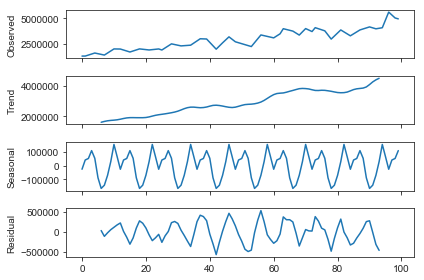

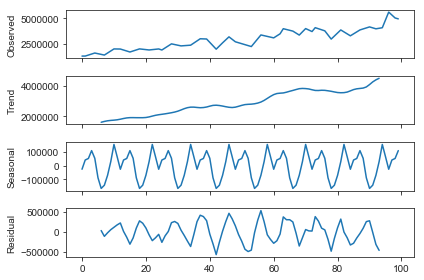

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(alldf['y'], model='additive', freq=12)
result.plot()

In [13]:
## OPTIONAL
## Run Normality Test and observe the qq plot

# from scipy import stats

# stat, p = stats.normaltest(tsdf.y)
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# alpha = 0.05
# if p > alpha:
#     print('Data looks Gaussian (fail to reject H0)')
# else:
#     print('Data does not look Gaussian (reject H0)')
    
# print('Kurtosis of Normal Dist: {}'.format(stats.kurtosis(tsdf.y)))
# print('Skewness of Normal Dist: {}'.format(stats.skew(tsdf.y)))    

# stats.probplot(tsdf['y'], plot=plt)

To measure causality among variables, we perform Granger Causality Test on each variable

from https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html:

"The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test."

"The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero."

"‘params_ftest’, ‘ssr_ftest’ are based on F distribution."

"‘ssr_chi2test’, ‘lrtest’ are based on chi-square distribution."

If the p-value is low (0.05), that means the variables are correlated with each other.

In [69]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test' 


df = pd.DataFrame(np.zeros((len(tsdf.columns), len(tsdf.columns))), columns=tsdf.columns, index=tsdf.columns)
for c in df.columns:
    for r in df.index:
        test_result = grangercausalitytests(tsdf[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
df.columns = [var + '_x' for var in tsdf.columns]
df.index = [var + '_y' for var in tsdf.columns]

grangerdf = df

grangerdf

D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  'rank is %d' % (J, J_), ValueWarning)
D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  'rank is %d' % (J, J_), ValueWarning)
D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 9
  'rank is %d' % (J, J_), ValueWarning)
D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have 

,y_x,"Gross domestic product, current prices_x","Inflation, average consumer prices_x",Net Trade_x
y_y,1.00,0.00,0.00,0.14
"Gross domestic product, current prices_y",0.02,1.00,0.00,0.00
"Inflation, average consumer prices_y",0.00,0.00,1.00,0.00
Net Trade_y,0.00,0.00,0.01,1.00


We can also perform Johansen Co-integration test to measure co-integration among variables within the combination of all the series altogether.
Co-integrated series are implied as having a long run, statistically significant relationships

In [15]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

alpha = 0.05
out = coint_johansen(tsdf,-1,5)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d[str(1-alpha)]]
def adjust(val, length= 6): 
    return str(val).ljust(length)

# # Summary
col_name =[]
trace_value = []
cvt_value = []
indicator = []
for col, trace, cvt in zip(tsdf.columns, traces, cvts):
    col_name.append(col)
    trace_value.append(np.round(trace, 2))
    cvt_value.append(cvt)
    indicator.append(trace> cvt)
    
d = {'Name':col_name, 'Test Stat' : trace_value, 'Critical Value (95%)': cvt_value, 'Significance': indicator} 
cj = pd.DataFrame(d)
cj[['Name', 'Test Stat', 'Critical Value (95%)', 'Significance']]

,Name,Test Stat,Critical Value (95%),Significance
0,y,43.31,40.17,True
1,"Gross domestic product, current prices",16.02,24.28,False
2,"Inflation, average consumer prices",6.87,12.32,False
3,Net Trade,0.27,4.13,False


Here we can purport that y has significant relationship with other macroeconomic indicators, but not those indicators themselves among the rest. This result is acceptable, since we only concern with the "status" of Net Sales (y) as it moves along with these macroeconomic measures.

In [16]:
## Split the data into training and testing

nobs = 10 ## we use the values on the last 10 months as the test set
df_train, df_test = tsdf[0:-nobs], tsdf[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(90, 4)
(10, 4)


We perform Augmented Dickey Fuller Test to check for stationarity of the training set

In [73]:
def adf(data,  variable=None, signif=0.05, verbose=False):

    r = adfuller(data, autolag='AIC')
    output = {'test_statistic':np.round(r[0], 4), 'pvalue':np.round(r[1], 4), 'n_lags':np.round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']

    # Print Summary
    print(' Augmented Dickey-Fuller Test on ', variable)
    print(' Null Hypothesis: Variable is Non-Stationary.')
    print(' Significance Level         = ', signif)
    print(' Test Statistic             = ', output["test_statistic"])
    print(' No. Lags Chosen (lowest AIC)= ', output["n_lags"])

    for key,val in r[4].items():
        print(' Critical value', key, np.round(val, 3))

    if p_value <= signif:
        print("p-Value = ", p_value, ". P value is less than critical value. Reject Null H. Series is Stationary.")
    else:
        print("p-Value = ", p_value, ".  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary")


In [74]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on  y
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -1.0268
 No. Lags Chosen (lowest AIC)=  5
 Critical value 10% -2.585
 Critical value 1% -3.511
 Critical value 5% -2.897
p-Value =  0.7434 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Augmented Dickey-Fuller Test on  Gross domestic product, current prices
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  0.0425
 No. Lags Chosen (lowest AIC)=  1
 Critical value 10% -2.585
 Critical value 1% -3.507
 Critical value 5% -2.895
p-Value =  0.9619 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Augmented Dickey-Fuller Test on  Inflation, average consumer prices
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic        

In [19]:
# 1st order differencing
df_differenced = df_train.diff().dropna()

# 2nd order differencing
df_differenced = df_differenced.diff().dropna()

Text(0.5, 1.0, 'Net Sales - 2nd order differenced')

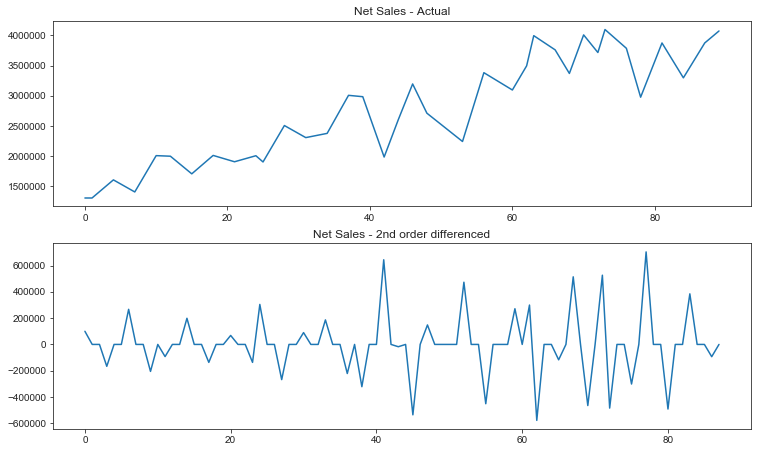

In [90]:
fig, ax = plt.subplots(2,1, figsize=(12.5,7.5))

df_train.reset_index()['y'].plot(ax=ax[0])
df_differenced.reset_index()['y'].plot(ax=ax[1])
ax[0].set_title('Net Sales - Actual')
ax[1].set_title('Net Sales - 2nd order differenced')

In [20]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on  y
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -7.7666
 No. Lags Chosen (lowest AIC)=  8
 Critical value 10% -2.587
 Critical value 1% -3.516
 Critical value 5% -2.899
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Augmented Dickey-Fuller Test on  Gross domestic product, current prices
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -9.2223
 No. Lags Chosen (lowest AIC)=  0
 Critical value 10% -2.585
 Critical value 1% -3.508
 Critical value 5% -2.895
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Augmented Dickey-Fuller Test on  Inflation, average consumer prices
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -9.2207
 No. Lags Chosen (lowest AIC)=  0
 Critical val

Plot Auto-correlation and partial auto-correlation plot before differencing
ACF and PACF further supports the hypothesis if the series is stationary or non-stationary

D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


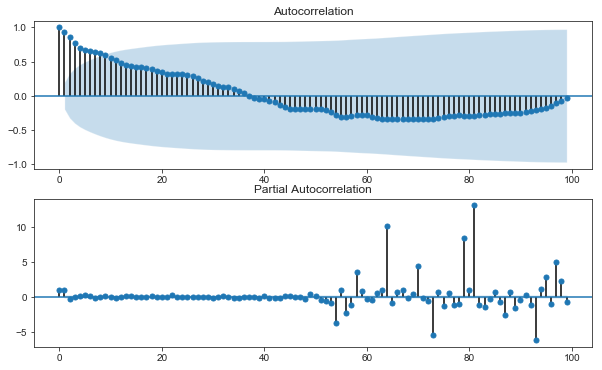

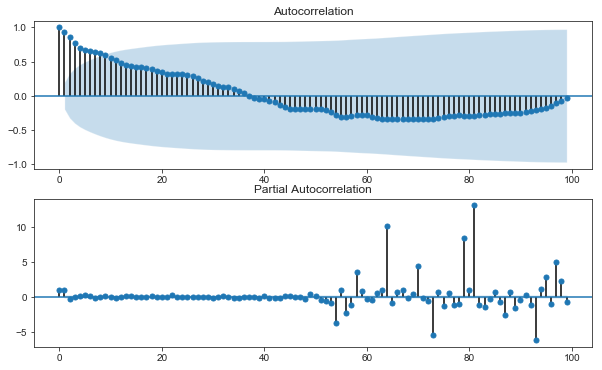

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(tsdf['y'], ax=ax[0])
plot_pacf(tsdf['y'], ax=ax[1])

ACF and PACF plot after differencing

D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


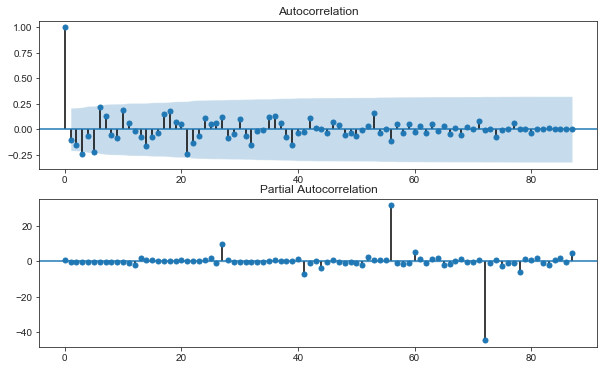

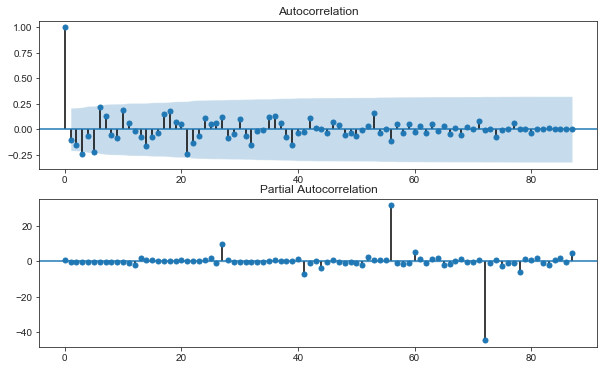

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df_differenced['y'], ax=ax[0])
plot_pacf(df_differenced['y'], ax=ax[1])

Calculate AIC and BIC, FPE, and HQIC for each lag

Rule of thumb: choose an optimal number of lag that minimizes AIC, or both AIC and BIC

In [23]:
# call the model and insert the differenced data
model = VAR(df_differenced)
x = model.select_order(maxlags=12)
x.summary()

D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,56.69,56.81*,4.172e+24,56.74
1,57.05,57.66,5.952e+24,57.29
2,57.35,58.45,8.103e+24,57.79
3,57.54,59.13,9.846e+24,58.17
4,57.70,59.79,1.181e+25,58.53
5,57.83,60.40,1.379e+25,58.86
6,58.00,61.07,1.719e+25,59.23
7,58.31,61.86,2.470e+25,59.73
8,58.54,62.59,3.397e+25,60.16
9,58.54,63.08,3.817e+25,60.36


In [24]:
## lag 4 seems decent, we choose lag 4 and fit it into the model 

model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, May, 2020
Time:                     19:39:30
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    59.7744
Nobs:                     84.0000    HQIC:                   58.5976
Log likelihood:          -2836.64    FPE:                1.30297e+25
AIC:                      57.8066    Det(Omega_mle):     6.23398e+24
--------------------------------------------------------------------
Results for equation y
                                               coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------
const                                         19960.868697     23714.740254            0.842           0.400
L1.y                                             -0.199201   

In [25]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(tsdf.columns, out):
    print(col, ':', round(val, 2))


y : 2.2
Gross domestic product, current prices : 2.01
Inflation, average consumer prices : 1.98
Net Trade : 2.02


In [26]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Separate input data for forecasting
# the goal is to forecast based on the last 4 inputs (since the lag is 4)
forecast_input = df_differenced.values[-lag_order:]

4


In [27]:
# Forecast
## we insert the last four values and inform the model to predict the next 10 values

fc = model_fitted.forecast(y=forecast_input, steps=nobs)

## organize the output into a clear DataFrame layout, add '_f' suffix at each column indicating they are the forecasted values
df_forecast = pd.DataFrame(fc, index=tsdf.index[-nobs:], columns=tsdf.columns + '_f')
df_forecast

,y_f,"Gross domestic product, current prices_f","Inflation, average consumer prices_f",Net Trade_f
ds,,,,
2019-06-01,43094.15,0.05,-0.00,-84779214.39
2019-07-01,36020.89,-0.05,-0.00,-86698280.11
2019-08-01,7912.04,0.05,0.00,-35819154.23
2019-09-01,-11083.55,0.03,0.00,-56073374.89
2019-10-01,-18167.70,0.02,-0.00,-65529629.57
2019-11-01,-7575.94,0.02,-0.00,-73371864.68
2019-12-01,11253.90,0.01,-0.00,-73350661.95
2020-01-01,11415.45,0.01,-0.00,-65848725.12
2020-02-01,5211.88,0.02,0.00,-57754631.57


We need to revert back the forecasted data to it's original scale, since we have taken first order difference on the train set

In [34]:
# get a copy of the forecast
df_fc = df_forecast.copy()

# get column name from the original dataframe
columns = df_train.columns

# Roll back from the 1st order differencing
# we take the cumulative sum (from the top row to the bottom) for each of the forecasting data, 
## and the add to the previous step's original value (since we deduct each row from the previous one)
## we rename the new forecasted column with the prefix 'forecast'

# for col in columns: 
#     df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_f'].cumsum()

## if you perform second order diff, make sure to get the difference from the last row and second last row of df_train
for col in columns:
    df_fc[str(col)+'_first_differenced'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_f'].cumsum()
    df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_first_differenced'].cumsum()
df_results = df_fc

In [35]:
df_results.loc[:, [ 'y_forecast', 
                    'Gross domestic product, current prices_forecast',     
                    'Inflation, average consumer prices_forecast', 
                    'Net Trade_forecast']]

,y_forecast,"Gross domestic product, current prices_forecast","Inflation, average consumer prices_forecast",Net Trade_forecast
ds,,,,
2019-06-01,4216966.15,4393.29,1.65,231674609446.71
2019-07-01,4395256.59,4401.68,1.59,229111343431.57
2019-08-01,4581459.08,4410.12,1.54,226512258262.20
2019-09-01,4756578.02,4418.59,1.49,223857099717.95
2019-10-01,4913529.27,4427.08,1.44,221136411544.13
2019-11-01,5062904.57,4435.59,1.39,218342351505.63
2019-12-01,5223533.77,4444.12,1.34,215474940805.19
2020-01-01,5395578.43,4452.65,1.28,212541681379.63
2020-02-01,5572834.96,4461.20,1.23,209550667322.49


In [36]:
forecast = df_results['y_forecast'].values
actual = df_test['y']

mae = np.mean(np.abs(forecast - actual))    # MAE
rmse = np.mean((forecast - actual)**2)**.5  # RMSE
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
print('Mean Absolute Error           : ', mae) 
print('Root Mean Squared Error       : ',rmse)
print('Mean Absolute Percentage Error: ',mape)

Mean Absolute Error           :  445641.1508824545
Root Mean Squared Error       :  522946.3865355065
Mean Absolute Percentage Error:  0.0999243747966973


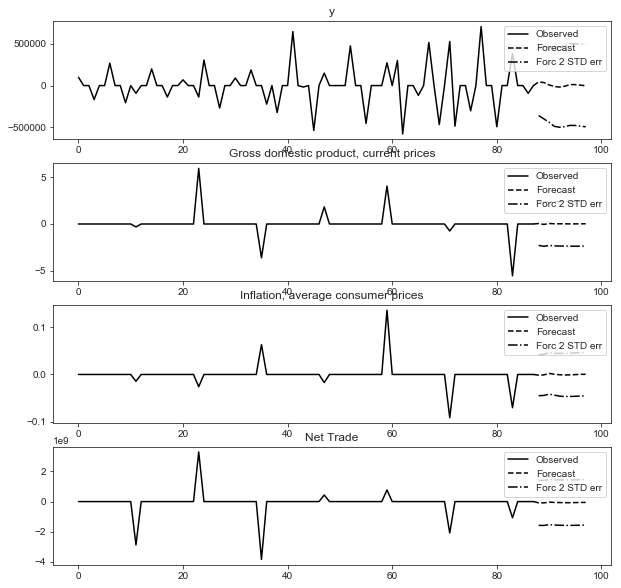

In [37]:
## you can use the statsmodels plot_forecast method but the output is not clean
fig = model_fitted.plot_forecast(10)

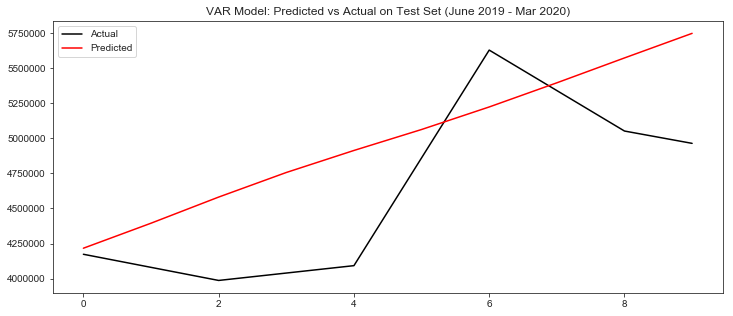

In [81]:
fig, ax = plt.subplots(figsize=(12, 5))

df_test.reset_index()['y'].plot(color='k', label='Actual')
df_results.reset_index()['y_forecast'].plot(color='r', label='Predicted')

plt.title('VAR Model: Predicted vs Actual on Test Set (June 2019 - Mar 2020)')
ax.legend()

# PROPHET

In [45]:
m = Prophet(seasonality_mode='multiplicative',
            growth='linear',
           yearly_seasonality=True,
            mcmc_samples=1000,
            changepoint_prior_scale = 0.001,
            )

# m.add_country_holidays(country_name='TH')

In [46]:
cols = np.array(alldf.columns)
modified_array = np.delete(cols, np.where(cols == 'y'))
modified_array2 = np.delete(modified_array, np.where(modified_array == 'ds'))
alldf_regressor = modified_array2

In [47]:
m.add_regressor('Gross domestic product, current prices', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Inflation, average consumer prices', prior_scale=0.5, mode='multiplicative')
m.add_regressor('Net Trade', prior_scale=0.5, mode='multiplicative')

In [48]:
m.fit(alldf)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [49]:
future = m.make_future_dataframe(periods=9, freq='MS')
future.tail(9)

,ds
100,2020-04-01
101,2020-05-01
102,2020-06-01
103,2020-07-01
104,2020-08-01
105,2020-09-01
106,2020-10-01
107,2020-11-01
108,2020-12-01


In [50]:
#####################
### BASELINE ASSUMPTION#####
### assuming everything stays at least constant at future, the key regressors will at least stays constant
#####

In [51]:
masterdf2 = masterdf.reset_index().rename(columns={'Date':'ds'})
masterdf2['ds'] = pd.to_datetime(masterdf2['ds'])
baseline_future = future.merge(masterdf2.loc[:, modified_array], how='left', on='ds')
baseline_future = baseline_future.fillna(method='ffill')
baseline_future = baseline_future.fillna(method='bfill')
baseline_future.tail(9)

,ds,"Gross domestic product, current prices","Inflation, average consumer prices",Net Trade
100,2020-04-01,4446.40,1.32,211460753462.37
101,2020-05-01,4447.11,1.31,209973777443.64
102,2020-06-01,4447.81,1.31,208486801424.91
103,2020-07-01,4448.52,1.30,206999825406.18
104,2020-08-01,4449.23,1.29,205512849387.45
105,2020-09-01,4449.94,1.28,204025873368.72
106,2020-10-01,4450.64,1.28,202538897349.99
107,2020-11-01,4451.35,1.27,201051921331.26
108,2020-12-01,4452.06,1.26,199564945312.53


In [52]:
forecast = m.predict(baseline_future)

result = pd.concat([forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], alldf[['y']]], 1)
result.tail(12)

,ds,yhat,yhat_lower,yhat_upper,y
97,2020-01-01,4812341.76,4203633.52,5317543.12,5340379.83
98,2020-02-01,4602959.25,4020711.68,5109847.49,5052009.66
99,2020-03-01,4869725.38,4272419.80,5411931.68,4964130.44
100,2020-04-01,4779906.86,4086165.47,5352073.17,nan
101,2020-05-01,4548127.58,3849339.42,5152965.32,nan
102,2020-06-01,4667529.50,3983386.73,5245195.01,nan
103,2020-07-01,4709128.55,4019718.80,5330025.49,nan
104,2020-08-01,4945246.29,4215482.03,5539015.16,nan
105,2020-09-01,5123178.79,4416604.81,5727071.63,nan
106,2020-10-01,5213828.87,4493401.37,5828175.19,nan


Text(0.5, 1.0, 'Net Sales - DEC 2020: BASELINE FORECAST ')

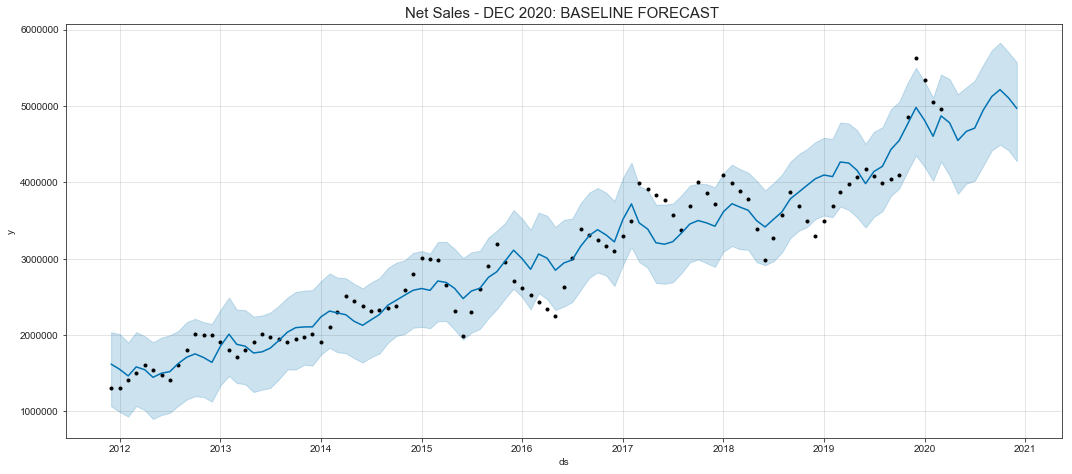

In [53]:
fig, ax = plt.subplots(figsize=(15, 6.5))

m.plot(forecast, ax=ax)
ax.set_title('Net Sales - DEC 2020: BASELINE FORECAST ', size=15)

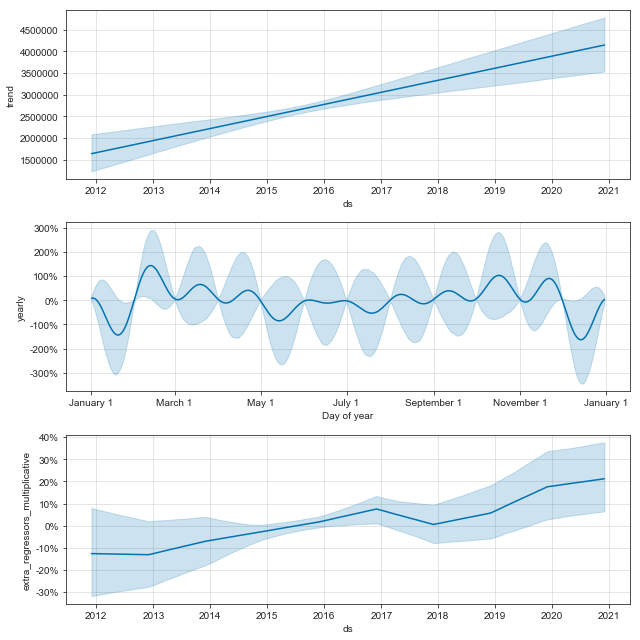

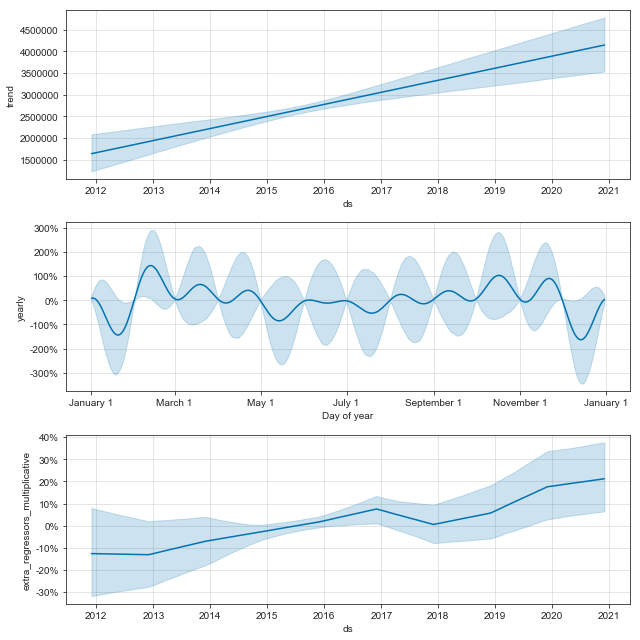

In [54]:
m.plot_components(forecast)

In [56]:
a = result.loc[pd.DatetimeIndex(result['ds']).year == 2019, 'y'].sum()
b = result.loc[pd.DatetimeIndex(result['ds']).year == 2020, 'yhat'].sum()

(b - a)/ a

0.16770085842897114

In [57]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, 
                         initial='730 days', # how many days we want to start training the data
                         period='90 days', # do the forecast every x days (in this case, every quarter)
                         horizon = '270 days'
                        )
df_cv.head()

INFO:fbprophet:Making 23 forecasts with cutoffs between 2014-01-02 00:00:00 and 2019-06-05 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
D:\Users\muhammad.taufik.azri\AppData\Local\Continuum\anaconda3\envs\gym\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-02-01,-5966.87,-2832906.45,2349049.79,2106787.38,2014-01-02
1,2014-03-01,-8141.16,-2831183.10,2432384.06,2307887.52,2014-01-02
2,2014-04-01,9224.95,-2706929.00,2480476.76,2508987.66,2014-01-02
3,2014-05-01,5653.19,-2754969.19,2760381.61,2442320.99,2014-01-02
4,2014-06-01,20578.62,-2709113.56,2840947.63,2375654.33,2014-01-02


In [58]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,26 days,230944266177.06,480566.61,418988.27,0.13,0.60
1,29 days,1078051852247.76,1038292.76,605580.42,0.21,0.60
2,30 days,1294751675412.21,1137871.55,693209.31,0.25,0.63
3,31 days,1289046232341.32,1135361.72,681450.52,0.25,0.65
4,33 days,1280359436314.72,1131529.69,667120.67,0.24,0.65


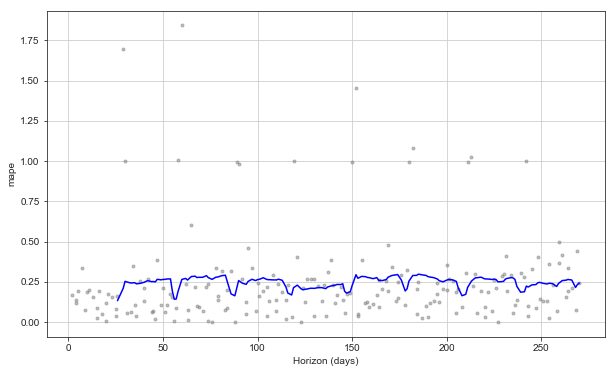

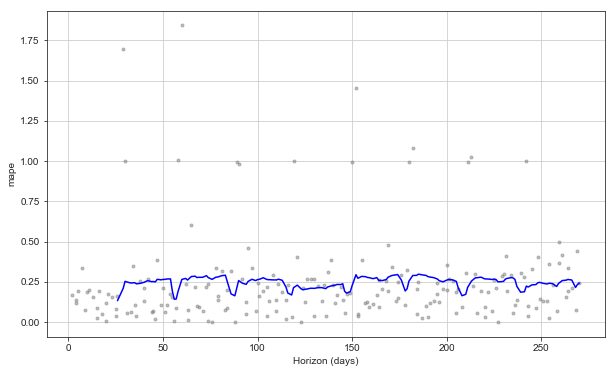

In [59]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='mape')

In [60]:
#####################
### SCENARIO ANALYSISN#####
### KEY INDICATORS DROPPED 5% FROM PAST MONTH'S VALUE UP TP DEC 2020
#####

In [61]:
future2 = future.merge(masterdf2.loc[:, modified_array], how='left', on='ds')

future2.iloc[-8:, 1:] = future2.iloc[-8:, 1:].apply(lambda x : x * 0.95)

scenario_forecast = m.predict(future2)
scenario_result = pd.concat([scenario_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], alldf[['y']]], 1)

In [62]:
future2.iloc[-8:, 1:] = future2.iloc[-8:, 1:].apply(lambda x : x * 0.95)

In [63]:
scenario_forecast = m.predict(future2)
scenario_result = pd.concat([scenario_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], alldf[['y']]], 1)
scenario_result.tail(12)

,ds,yhat,yhat_lower,yhat_upper,y
97,2020-01-01,4812341.76,4205648.61,5363771.03,5340379.83
98,2020-02-01,4602959.25,3991877.96,5112821.21,5052009.66
99,2020-03-01,4869725.38,4246148.12,5397496.76,4964130.44
100,2020-04-01,4779906.86,4116888.62,5340410.69,nan
101,2020-05-01,4241933.01,3406702.63,5114990.38,nan
102,2020-06-01,4358340.95,3497841.50,5236766.56,nan
103,2020-07-01,4396991.11,3563852.68,5293639.44,nan
104,2020-08-01,4630087.29,3704532.10,5560187.62,nan
105,2020-09-01,4804984.34,3880740.32,5734527.41,nan
106,2020-10-01,4892644.75,3940835.17,5866646.39,nan


Text(0.5, 1.0, 'Net Sales - SCENARIO FORECAST UP TO DEC 2020')

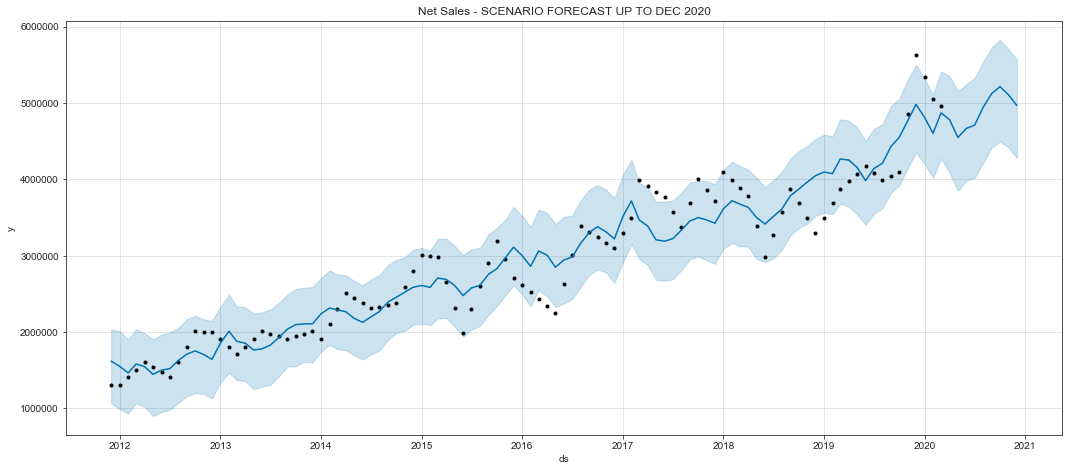

In [64]:
fig, ax = plt.subplots(figsize=(15, 6.5))

m.plot(forecast, ax=ax)
ax.set_title('Net Sales - SCENARIO FORECAST UP TO DEC 2020')

In [65]:
a = scenario_result.loc[pd.DatetimeIndex(scenario_result['ds']).year == 2019, 'y'].sum()
b = scenario_result.loc[pd.DatetimeIndex(scenario_result['ds']).year == 2020, 'yhat'].sum()

(b - a) / a

0.11699488598006727